
# Project: Investigate a Dataset - [No Show Appointments]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.

- ‘ScheduledDay’ tells us on what day the patient set up their appointment.
- ‘Neighborhood’ indicates the location of the hospital.
- ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
- Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.


### Question(s) for Analysis
- What is the overall appointment show-up vs. no show-up rate
- What age commitment to appointments
- What gender have most make appointments
- what gender does not show up most of the time
- What are the most characteristics affect show-ups rate ('alcoholic','Having an SMS'), to make the patient make it to his appiontment?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling


### General Properties
> The Pandas library will be used to work with the data. The following commands will low that dataset into a pandas dataframe and display basic information about it.



In [2]:
#read dataset
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
#Summary for the data
df.describe()


,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [3]:
#check count of rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
#check null values
df.isna().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

> The ouput shows that there are 110,527 entries described by 14 fields. There are also no null fields confirmed using two ways.



In [5]:
df.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No



### Data Cleaning
> The output also exposed outliers in the Age field that could potentially be errors. The youngest person is -1 and the oldest is 115. Boxplots provide a way to visually identify outliers.
>
> Date Time Format need to be fixed
>
> Fix some typos in data columns
 

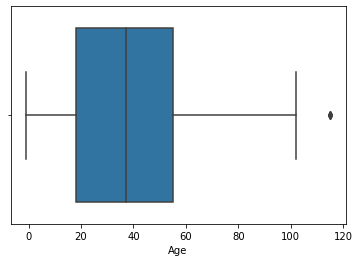

In [6]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
sns.boxplot(df.Age)
plt.show();


In [7]:
df[df['Age']<0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [8]:
df[df['Age']>95]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
969,1.294694e+14,5588126,F,2016-04-15T09:36:46Z,2016-04-29T00:00:00Z,98,BONFIM,0,1,0,0,0,0,Yes
983,8.249688e+13,5520168,M,2016-03-29T09:38:12Z,2016-04-29T00:00:00Z,98,SÃO PEDRO,0,1,0,0,0,1,No
5401,3.518546e+11,5675430,M,2016-05-09T13:42:53Z,2016-05-11T00:00:00Z,96,JARDIM DA PENHA,0,0,0,0,0,0,No
9437,8.758612e+13,5692481,F,2016-05-12T15:27:57Z,2016-05-18T00:00:00Z,96,MARUÍPE,0,1,0,0,0,0,No
14176,1.882198e+11,5732443,F,2016-05-24T11:30:52Z,2016-05-24T00:00:00Z,96,JABOUR,0,0,0,0,0,0,No
14345,6.451675e+13,5721500,M,2016-05-19T16:46:02Z,2016-05-20T00:00:00Z,96,SANTO ANDRÉ,0,1,0,0,0,0,No
18317,5.659244e+14,5704081,F,2016-05-16T15:03:03Z,2016-05-16T00:00:00Z,97,PARQUE MOSCOSO,0,1,1,0,0,0,No
23389,3.794954e+13,5695368,F,2016-05-13T10:04:35Z,2016-05-13T00:00:00Z,96,CONSOLAÇÃO,0,1,0,0,1,0,No
24127,5.253828e+14,5682354,F,2016-05-10T16:20:23Z,2016-05-10T00:00:00Z,97,SANTA TEREZA,0,1,0,0,0,0,No
24129,5.234117e+14,5664305,F,2016-05-05T11:49:10Z,2016-05-05T00:00:00Z,96,DO QUADRO,0,1,0,0,0,0,No


In [9]:
df = df[(df['Age'] > 0 ) & (df['Age'] <= 95)]
df[df['Age']<=0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


In [10]:
df[df['Age']>95]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


In [11]:
# converting some columns that has date to a datetime datatype
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])


In [12]:
df.rename(columns = {'Hipertension': 'Hypertension',
                'Handcap': 'Handicap','No-show':'Show'}, inplace = True)


In [13]:
df['Show'].replace('No',True,inplace=True)
df['Show'].replace('Yes',False,inplace=True)
df["Show"] = df["Show"].astype(int)


> Changed column no-show name and it's values as it will be confusing in analytics

In [14]:
df

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,1
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03 09:15:35+00:00,2016-06-07 00:00:00+00:00,56,MARIA ORTIZ,0,0,0,0,0,1,1
110523,3.596266e+12,5650093,F,2016-05-03 07:27:33+00:00,2016-06-07 00:00:00+00:00,51,MARIA ORTIZ,0,0,0,0,0,1,1
110524,1.557663e+13,5630692,F,2016-04-27 16:03:52+00:00,2016-06-07 00:00:00+00:00,21,MARIA ORTIZ,0,0,0,0,0,1,1
110525,9.213493e+13,5630323,F,2016-04-27 15:09:23+00:00,2016-06-07 00:00:00+00:00,38,MARIA ORTIZ,0,0,0,0,0,1,1


<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 (what is the overall appointment show-up vs. no show-up rate?)
> making a pie chart to have the percentage of who showed up and who is not


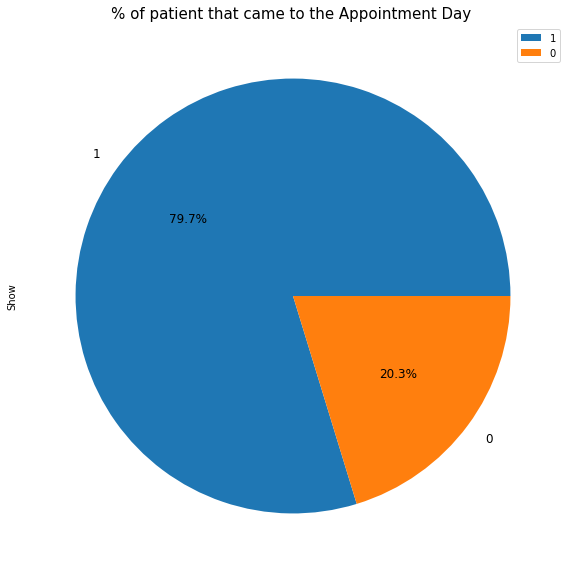

In [15]:
allP = df['Show'].value_counts()
pieChart = allP.plot.pie(figsize=(10,10), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title(f'% of patient that came to the Appointment Day ', fontsize = 15);
plt.legend();


> As we can see 20.3 % didn't show up for their appointments

### ### Research Question 2 (What age commitment to appointments)

In [16]:
def show_filter(df):
    df_true = df[df['Show']==True]
    df_false = df[df['Show']==False]
    return df_true,df_false

In [17]:
df_true , df_false = show_filter(df)
grouped_true = df_true.groupby(['Age']).count()['Show']

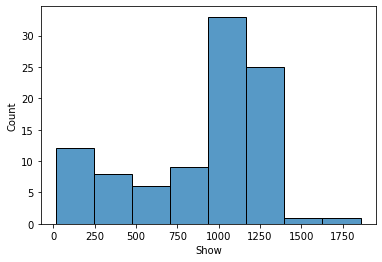

In [18]:
sns.histplot(grouped_true);

> As we can see the most commitment to appointments by age are around 30's

In [19]:
grouped_false = df_false.groupby(['Age']).count()['Show']

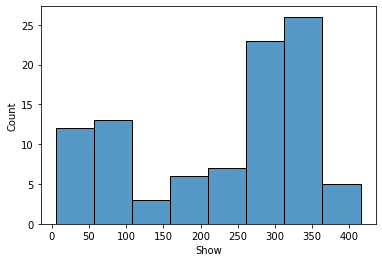

In [20]:
sns.histplot(grouped_false);

> While most of skiping appointments around 25's

In [21]:
df.groupby('Show')['Age'].mean().to_frame()

,Age
Show,
0,35.306741
1,39.048119


> the average show up age is 39 and no show age 35.3 

### Research Question 3 (What gender have most make appointments)

In [22]:
grouped_gender = df.groupby(['Gender']).count()['Show']
grouped_gender.to_frame(name='Number of Appointments Per Gender')

,Number of Appointments Per Gender
Gender,
F,70081
M,36860


> As we can see Females make more appointments more males 

### Research Question 4 (What gender does not show up most of the time)

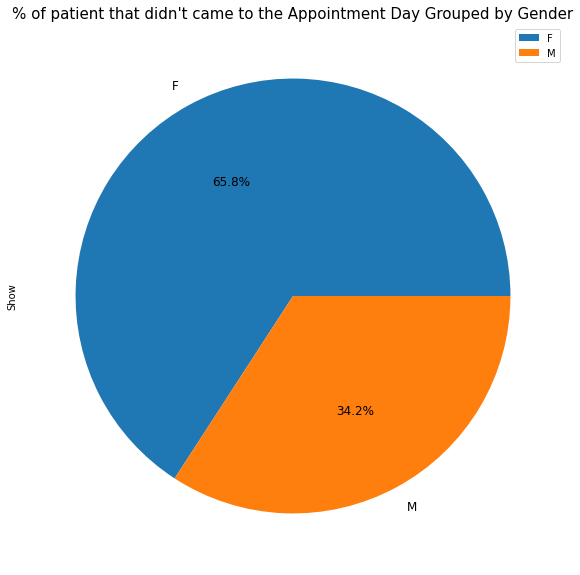

In [23]:
grouped_gender_false = df_false.groupby(['Gender']).count()['Show']
pieChart_grouped = grouped_gender_false.plot.pie(figsize=(10,10), autopct='%1.1f%%', fontsize = 12);
pieChart_grouped.set_title(f"% of patient that didn't came to the Appointment Day Grouped by Gender", fontsize = 15);
plt.legend();


> As we can see Number of patient that didn't show up to the Appointment Day Grouped by Gender Females are more let's dig in some more

In [24]:
grouped_gender_false.to_frame(name="Number patient that didn't came to the Appointment Day Grouped by Gender")

,Number patient that didn't came to the Appointment Day Grouped by Gender
Gender,
F,14269
M,7404


> Females more than double of number of patient that didn't came to the Appointment Day Grouped by Gender 

### Research Question 5 (What are the most characteristics affect show-ups rate ('alcoholic','Having an SMS'), to make the patient make it to his appiontment?)

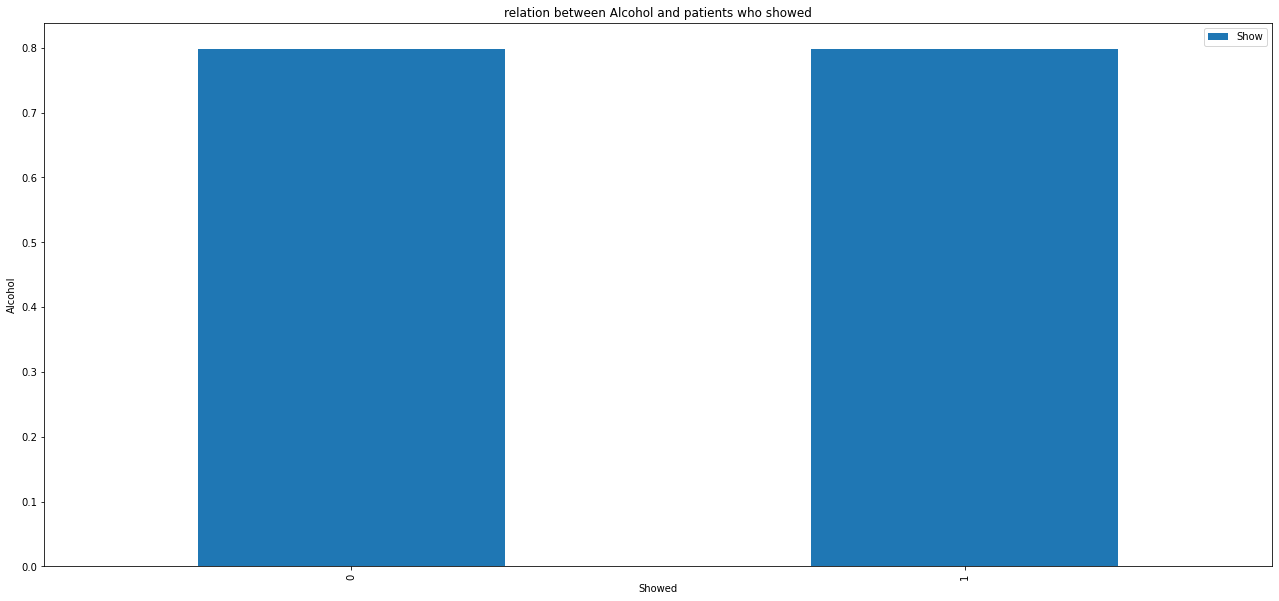

In [25]:
# mean for Alcoholism is it affect show up rate?
alcholic_showed = df.groupby(['Alcoholism']).mean()['Show']
alcholic_showed.plot(kind='bar',figsize=(22,10));
plt.xlabel("Showed")
plt.ylabel("Alcohol")
plt.title("relation between Alcohol and patients who showed")
plt.legend();

> mean shows that they are very close lets see in numbers which means doesn't matter if showed or not due to being alcoholic

In [26]:
alcholic_showed = df_true.groupby(['Alcoholism']).count()['Show']
alcholic_showed.to_frame('Number of alcholic vs not alcholic showed')

,Number of alcholic vs not alcholic showed
Alcoholism,
0,82585
1,2683


In [27]:
alcholic_didnt_showed = df_false.groupby(['Alcoholism']).count()['Show']
alcholic_didnt_showed.to_frame('Number of alcholic vs not alcholic not showed')

,Number of alcholic vs not alcholic not showed
Alcoholism,
0,20996
1,677


> where 0 is not alcohlic and 1 is alcholic 
> we can Alcholism don't affect that much as 2683 alcholic patient and showed vs 677 alcholic patients and didn't show.

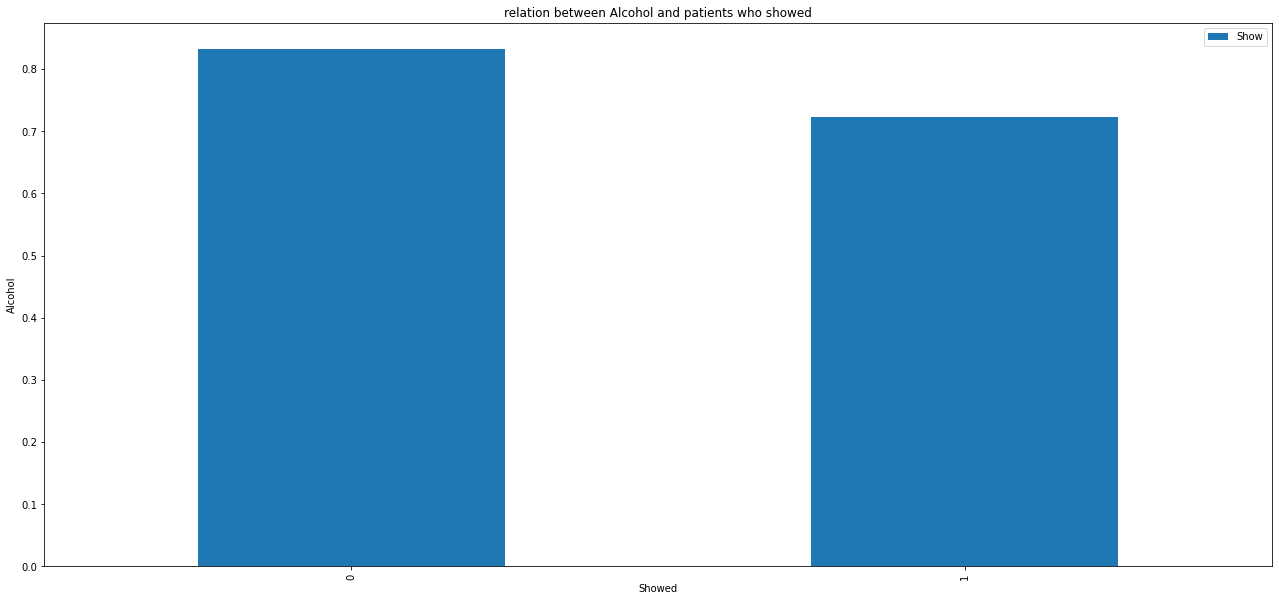

In [28]:
# mean for SMS_received is it affect show up rate?
alcholic_showed = df.groupby(['SMS_received']).mean()['Show']
alcholic_showed.plot(kind='bar',figsize=(22,10));
plt.xlabel("Showed")
plt.ylabel("Alcohol")
plt.title("relation between Alcohol and patients who showed")
plt.legend();

> mean shows that they are very close lets see in numbers which means doesn't matter if showed or not for reciving sms

In [29]:
alcholic_showed = df_true.groupby(['SMS_received']).count()['Show']
alcholic_showed.to_frame('Number of alcholic vs not alcholic showed')

,Number of alcholic vs not alcholic showed
SMS_received,
0,60255
1,25013


In [30]:
alcholic_didnt_showed = df_false.groupby(['SMS_received']).count()['Show']
alcholic_didnt_showed.to_frame('Number of alcholic vs not alcholic not showed')

,Number of alcholic vs not alcholic not showed
SMS_received,
0,12105
1,9568


> as we can see number of sms increased % of patients to show up little bit as 9K didn't show up after reciving sms while 25K show up after reciving sms

<a id='conclusions'></a>
## Limitations:

#### Non-existent factors may be helpful in determining which factors are most likely to contribute to showing to the appointment such as whether the patient is employeed or not, or whether the patient has a series of medical problems or not as a cancer.
#### there we some illogical data such as patients with age 0 or less & 100 and above

## conclusions:


- SMS_recived increased show up by little so sending SMS will increase show up but not that much
- Alcohol don't impact that much so little of alcoholic patients don't show up
- The average show up age is 39 and no show age 35.3 
- As we can see about 20.3% of people that schedule an appointment did not show up for thier appointment
- Females more likely to miss their appointment


## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [31]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

1